In [1]:
import warnings 
warnings.filterwarnings("ignore")

from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    LabelFilterd,
    LoadImaged,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    Resized,
    ScaleIntensityRanged,
    SpatialCrop,
    SpatialCropd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob

import numpy as np

import itk

import site
site.addsitedir('../../../ARGUS')
from ARGUSUtils_Transforms import *

In [4]:
img1_dir = "../../../Data/VFoldData/BAMC-PTX*Sliding-Annotations-Linear/"
    
all_images = sorted(glob(os.path.join(img1_dir, '*_?????.nii.gz')))
all_labels = sorted(glob(os.path.join(img1_dir, '*.extruded-overlay-S.nii.gz')))

gpu_device = 0

num_folds = 15

num_classes = 2

num_workers_tr = 4
batch_size_tr = 8
num_workers_vl = 2
batch_size_vl = 1

num_slices = 48
size_x = 320
size_y = 320

max_epochs = 500
net_channels=(16, 32, 64, 64)
net_strides=(1, 2, 2)

model_filename_base = "./results/BAMC_PTX_3DUNet-S-Extruded.best_model.vfold"

num_images = len(all_images)
print(num_images)

ns_prefix = ['025ns','026ns','027ns','035ns','048ns','055ns','117ns',
             '135ns','193ns','210ns','215ns','218ns','219ns','221ns','247ns']
s_prefix = ['004s','019s','030s','034s','037s','043s','065s','081s',
            '206s','208s','211s','212s','224s','228s','236s','237s']

fold_prefix_list = []
ns_count = 0
s_count = 0
for i in range(num_folds):
    if i%2 == 0:
        num_ns = 1
        num_s = 1
        if i > num_folds-3:
            num_s = 2
    else:
        num_ns = 1
        num_s = 1
    f = []
    for ns in range(num_ns):
        f.append([ns_prefix[ns_count+ns]])
    ns_count += num_ns
    for s in range(num_s):
        f.append([s_prefix[s_count+s]])
    s_count += num_s
    fold_prefix_list.append(f)
        
train_files = []
val_files = []
test_files = []
for i in range(num_folds):
    tr_folds = []
    for f in range(i,i+num_folds-2):
        tr_folds.append(fold_prefix_list[f%num_folds])
    tr_folds = list(np.concatenate(tr_folds).flat)
    va_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-2) % num_folds]).flat)
    te_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-1) % num_folds]).flat)
    train_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in tr_folds)],
                    [se for se in all_labels if any(pref in se for pref in tr_folds)])
            ]
        )
    val_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in va_folds)],
                    [se for se in all_labels if any(pref in se for pref in va_folds)])
            ]
        )
    test_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in te_folds)],
                    [se for se in all_labels if any(pref in se for pref in te_folds)])
            ]
        )
    print(len(train_files[i]),len(val_files[i]),len(test_files[i]))

62
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0


In [3]:
imgnum = 1 #10 for ns, 0 for s

print(train_files[0][imgnum]["image"])
print(train_files[0][imgnum]["label"])

img = itk.imread(train_files[0][imgnum]["image"])
arrimg = itk.GetArrayFromImage(img)
img = itk.imread(train_files[0][imgnum]["label"])
arrlbl = itk.GetArrayFromImage(img)

plt.subplots()
plt.imshow(arrimg[0,:,:])
plt.subplots()
plt.imshow(arrlbl[0,:,:])


IndexError: list index out of range

In [4]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(keys=["image"],
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0),
        Resized(keys=["image", "label"],
            spatial_size=[320,320,60],
            mode=['trilinear', 'nearest']),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=num_slices,
            axis=3,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=2,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=0,
            keys=['image', 'label']),
        RandZoomd(prob=0.5, 
            min_zoom=1.0,
            max_zoom=1.2,
            keys=['image', 'label'],
            keep_size=True,
            mode=['trilinear', 'nearest']),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(keys=["image"],
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0),
        Resized(keys=["image", "label"],
            spatial_size=[320,320,60],
            mode=['trilinear', 'nearest']),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=num_slices,
            axis=3,
            center_slice=30,
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)

In [5]:
train_ds = [CacheDataset(data=train_files[i], transform=train_transforms,cache_rate=1.0, num_workers=num_workers_tr)
            for i in range(num_folds)]
train_loader = [DataLoader(train_ds[i], batch_size=batch_size_tr, shuffle=True, num_workers=num_workers_tr) 
                for i in range(num_folds)]

val_ds = [CacheDataset(data=val_files[i], transform=val_transforms, cache_rate=1.0, num_workers=num_workers_vl)
          for i in range(num_folds)]
val_loader = [DataLoader(val_ds[i], batch_size=batch_size_vl, num_workers=num_workers_vl)
              for i in range(num_folds)]

Loading dataset: 100%|████████████████████████████| 4/4 [00:00<00:00,  5.76it/s]


torch.Size([1, 1, 320, 320, 48])
torch.Size([320, 320, 48])
image shape: torch.Size([320, 320, 48]), label shape: torch.Size([320, 320, 48])


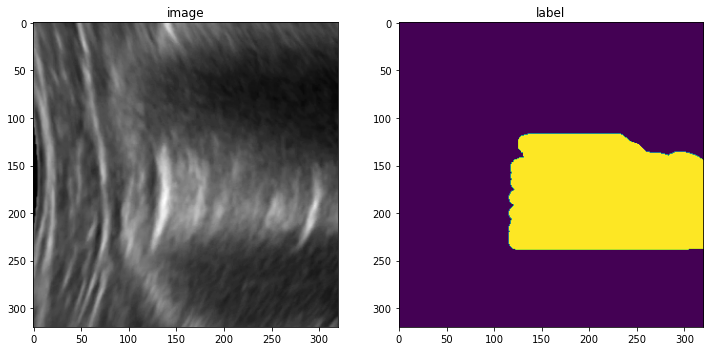

tensor(0.) tensor(1.)


In [6]:
imgnum = 0
check_data = first(val_loader[0])
image, label = (check_data["image"][imgnum][0], check_data["label"][imgnum][0])
print(check_data["image"].shape)
print(image.shape)
print(f"image shape: {image.shape}, label shape: {label.shape}")
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 2], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 2])
plt.show()
print(label.min(), label.max())

In [7]:
device = torch.device("cuda:"+str(gpu_device))

In [8]:
def vfold_train(vfold_num, train_loader, val_loader):
    model = UNet(
        dimensions=3,
        in_channels=1,
        out_channels=num_classes,
        channels=net_channels,
        strides=net_strides,
        num_res_units=2,
        norm=Norm.BATCH,
    ).to(device)
    loss_function = DiceLoss(to_onehot_y=True, softmax=True)
    optimizer = torch.optim.Adam(model.parameters(), 1e-4)
    dice_metric = DiceMetric(include_background=False, reduction="mean")

    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []

    post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, num_classes=num_classes)])
    post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, num_classes=num_classes)])

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"{vfold_num}: epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(f"{step}/{len(train_ds) // train_loader.batch_size}, "
                  f"train_loss: {loss.item():.4f}")
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"{vfold_num} epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )
                    roi_size = (size_x, size_y, num_slices)
                    sw_batch_size = batch_size_vl
                    val_outputs = sliding_window_inference(
                        val_inputs, roi_size, sw_batch_size, model)
                    val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                    # compute metric for current iteration
                    dice_metric(y_pred=val_outputs, y=val_labels)

                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()
                # reset the status for next validation round
                dice_metric.reset()

                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), model_filename_base+'_'+str(vfold_num)+'.pth')
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )

    np.save(model_filename_base+"_loss_"+str(vfold_num)+".npy", epoch_loss_values)
    np.save(model_filename_base+"_val_dice_"+str(vfold_num)+".npy", metric_values)

In [9]:
for i in range(gpu_device,num_folds,4):
    vfold_train(i, train_loader[i], val_loader[i])    

----------
0: epoch 1/500
1/1, train_loss: 0.7671
2/1, train_loss: 0.7665
3/1, train_loss: 0.7472
4/1, train_loss: 0.7611
5/1, train_loss: 0.7500
6/1, train_loss: 0.7461
7/1, train_loss: 0.7557
0 epoch 1 average loss: 0.7562
----------
0: epoch 2/500
1/1, train_loss: 0.7397
2/1, train_loss: 0.7525
3/1, train_loss: 0.7383
4/1, train_loss: 0.7346
5/1, train_loss: 0.7345
6/1, train_loss: 0.7350
7/1, train_loss: 0.7219
0 epoch 2 average loss: 0.7367
saved new best metric model
current epoch: 2 current mean dice: 0.2465
best mean dice: 0.2465 at epoch: 2
----------
0: epoch 3/500
1/1, train_loss: 0.7360
2/1, train_loss: 0.7211
3/1, train_loss: 0.7240
4/1, train_loss: 0.7144
5/1, train_loss: 0.7273
6/1, train_loss: 0.7374
7/1, train_loss: 0.7194
0 epoch 3 average loss: 0.7257
----------
0: epoch 4/500
1/1, train_loss: 0.7288
2/1, train_loss: 0.7200
3/1, train_loss: 0.7261
4/1, train_loss: 0.7012
5/1, train_loss: 0.7150
6/1, train_loss: 0.7115
7/1, train_loss: 0.7196
0 epoch 4 average loss: 0

1/1, train_loss: 0.6020
2/1, train_loss: 0.6177
3/1, train_loss: 0.5943
4/1, train_loss: 0.6011
5/1, train_loss: 0.5710
6/1, train_loss: 0.5889
7/1, train_loss: 0.6516
0 epoch 31 average loss: 0.6038
----------
0: epoch 32/500
1/1, train_loss: 0.5972
2/1, train_loss: 0.5682
3/1, train_loss: 0.6187
4/1, train_loss: 0.5793
5/1, train_loss: 0.6035
6/1, train_loss: 0.6005
7/1, train_loss: 0.5894
0 epoch 32 average loss: 0.5938
current epoch: 32 current mean dice: 0.1982
best mean dice: 0.5986 at epoch: 26
----------
0: epoch 33/500
1/1, train_loss: 0.5862
2/1, train_loss: 0.6014
3/1, train_loss: 0.5858
4/1, train_loss: 0.6010
5/1, train_loss: 0.5796
6/1, train_loss: 0.6141
7/1, train_loss: 0.5879
0 epoch 33 average loss: 0.5937
----------
0: epoch 34/500
1/1, train_loss: 0.5992
2/1, train_loss: 0.5991
3/1, train_loss: 0.5776
4/1, train_loss: 0.6005
5/1, train_loss: 0.6171
6/1, train_loss: 0.5739
7/1, train_loss: 0.6109
0 epoch 34 average loss: 0.5969
current epoch: 34 current mean dice: 0.

7/1, train_loss: 0.5049
0 epoch 61 average loss: 0.5379
----------
0: epoch 62/500
1/1, train_loss: 0.5282
2/1, train_loss: 0.5484
3/1, train_loss: 0.5045
4/1, train_loss: 0.5810
5/1, train_loss: 0.5221
6/1, train_loss: 0.5771
7/1, train_loss: 0.5330
0 epoch 62 average loss: 0.5420
current epoch: 62 current mean dice: 0.2318
best mean dice: 0.6511 at epoch: 44
----------
0: epoch 63/500
1/1, train_loss: 0.5669
2/1, train_loss: 0.5443
3/1, train_loss: 0.5330
4/1, train_loss: 0.5449
5/1, train_loss: 0.5191
6/1, train_loss: 0.5437
7/1, train_loss: 0.5411
0 epoch 63 average loss: 0.5419
----------
0: epoch 64/500
1/1, train_loss: 0.5294
2/1, train_loss: 0.5534
3/1, train_loss: 0.5233
4/1, train_loss: 0.5485
5/1, train_loss: 0.5453
6/1, train_loss: 0.5150
7/1, train_loss: 0.5106
0 epoch 64 average loss: 0.5322
current epoch: 64 current mean dice: 0.2257
best mean dice: 0.6511 at epoch: 44
----------
0: epoch 65/500
1/1, train_loss: 0.5166
2/1, train_loss: 0.5330
3/1, train_loss: 0.5378
4/1,

4/1, train_loss: 0.5008
5/1, train_loss: 0.4878
6/1, train_loss: 0.5143
7/1, train_loss: 0.5288
0 epoch 92 average loss: 0.5079
current epoch: 92 current mean dice: 0.4423
best mean dice: 0.6817 at epoch: 84
----------
0: epoch 93/500
1/1, train_loss: 0.4994
2/1, train_loss: 0.4998
3/1, train_loss: 0.5140
4/1, train_loss: 0.4905
5/1, train_loss: 0.5184
6/1, train_loss: 0.5036
7/1, train_loss: 0.5196
0 epoch 93 average loss: 0.5065
----------
0: epoch 94/500
1/1, train_loss: 0.4773
2/1, train_loss: 0.5015
3/1, train_loss: 0.5391
4/1, train_loss: 0.5466
5/1, train_loss: 0.4903
6/1, train_loss: 0.4931
7/1, train_loss: 0.4845
0 epoch 94 average loss: 0.5046
current epoch: 94 current mean dice: 0.6398
best mean dice: 0.6817 at epoch: 84
----------
0: epoch 95/500
1/1, train_loss: 0.4815
2/1, train_loss: 0.5157
3/1, train_loss: 0.5019
4/1, train_loss: 0.5130
5/1, train_loss: 0.5072
6/1, train_loss: 0.5301
7/1, train_loss: 0.5122
0 epoch 95 average loss: 0.5088
----------
0: epoch 96/500
1/1,

current epoch: 122 current mean dice: 0.3271
best mean dice: 0.6817 at epoch: 84
----------
0: epoch 123/500
1/1, train_loss: 0.4804
2/1, train_loss: 0.4825
3/1, train_loss: 0.4704
4/1, train_loss: 0.4665
5/1, train_loss: 0.4920
6/1, train_loss: 0.5261
7/1, train_loss: 0.4926
0 epoch 123 average loss: 0.4872
----------
0: epoch 124/500
1/1, train_loss: 0.4727
2/1, train_loss: 0.4626
3/1, train_loss: 0.4877
4/1, train_loss: 0.4690
5/1, train_loss: 0.5016
6/1, train_loss: 0.4942
7/1, train_loss: 0.5013
0 epoch 124 average loss: 0.4842
current epoch: 124 current mean dice: 0.2438
best mean dice: 0.6817 at epoch: 84
----------
0: epoch 125/500
1/1, train_loss: 0.5386
2/1, train_loss: 0.5078
3/1, train_loss: 0.4828
4/1, train_loss: 0.4678
5/1, train_loss: 0.4634
6/1, train_loss: 0.4537
7/1, train_loss: 0.4649
0 epoch 125 average loss: 0.4827
----------
0: epoch 126/500
1/1, train_loss: 0.4580
2/1, train_loss: 0.4663
3/1, train_loss: 0.4768
4/1, train_loss: 0.4998
5/1, train_loss: 0.4819
6/1

1/1, train_loss: 0.4780
2/1, train_loss: 0.4669
3/1, train_loss: 0.4900
4/1, train_loss: 0.4860
5/1, train_loss: 0.4455
6/1, train_loss: 0.4824
7/1, train_loss: 0.4786
0 epoch 153 average loss: 0.4753
----------
0: epoch 154/500
1/1, train_loss: 0.4682
2/1, train_loss: 0.4799
3/1, train_loss: 0.4668
4/1, train_loss: 0.4648
5/1, train_loss: 0.4753
6/1, train_loss: 0.4662
7/1, train_loss: 0.4481
0 epoch 154 average loss: 0.4670
current epoch: 154 current mean dice: 0.2997
best mean dice: 0.7199 at epoch: 144
----------
0: epoch 155/500
1/1, train_loss: 0.4590
2/1, train_loss: 0.4755
3/1, train_loss: 0.4690
4/1, train_loss: 0.4898
5/1, train_loss: 0.4619
6/1, train_loss: 0.4857
7/1, train_loss: 0.5325
0 epoch 155 average loss: 0.4819
----------
0: epoch 156/500
1/1, train_loss: 0.4767
2/1, train_loss: 0.4613
3/1, train_loss: 0.4445
4/1, train_loss: 0.4603
5/1, train_loss: 0.4968
6/1, train_loss: 0.4736
7/1, train_loss: 0.4936
0 epoch 156 average loss: 0.4724
current epoch: 156 current mea

5/1, train_loss: 0.4640
6/1, train_loss: 0.4835
7/1, train_loss: 0.4837
0 epoch 183 average loss: 0.4668
----------
0: epoch 184/500
1/1, train_loss: 0.4557
2/1, train_loss: 0.4482
3/1, train_loss: 0.4608
4/1, train_loss: 0.4799
5/1, train_loss: 0.4388
6/1, train_loss: 0.4798
7/1, train_loss: 0.4562
0 epoch 184 average loss: 0.4599
current epoch: 184 current mean dice: 0.5790
best mean dice: 0.7199 at epoch: 144
----------
0: epoch 185/500
1/1, train_loss: 0.4662
2/1, train_loss: 0.4513
3/1, train_loss: 0.4564
4/1, train_loss: 0.4459
5/1, train_loss: 0.4520
6/1, train_loss: 0.4760
7/1, train_loss: 0.4968
0 epoch 185 average loss: 0.4635
----------
0: epoch 186/500
1/1, train_loss: 0.4336
2/1, train_loss: 0.4576
3/1, train_loss: 0.4611
4/1, train_loss: 0.4546
5/1, train_loss: 0.4718
6/1, train_loss: 0.4790
7/1, train_loss: 0.4966
0 epoch 186 average loss: 0.4649
current epoch: 186 current mean dice: 0.6197
best mean dice: 0.7199 at epoch: 144
----------
0: epoch 187/500
1/1, train_loss:

1/1, train_loss: 0.4311
2/1, train_loss: 0.4350
3/1, train_loss: 0.4869
4/1, train_loss: 0.4440
5/1, train_loss: 0.5006
6/1, train_loss: 0.4578
7/1, train_loss: 0.4648
0 epoch 214 average loss: 0.4600
current epoch: 214 current mean dice: 0.5404
best mean dice: 0.7199 at epoch: 144
----------
0: epoch 215/500
1/1, train_loss: 0.4836
2/1, train_loss: 0.4500
3/1, train_loss: 0.4392
4/1, train_loss: 0.4645
5/1, train_loss: 0.4279
6/1, train_loss: 0.4731
7/1, train_loss: 0.4709
0 epoch 215 average loss: 0.4585
----------
0: epoch 216/500
1/1, train_loss: 0.4437
2/1, train_loss: 0.4356
3/1, train_loss: 0.4576
4/1, train_loss: 0.4844
5/1, train_loss: 0.4464
6/1, train_loss: 0.4375
7/1, train_loss: 0.4602
0 epoch 216 average loss: 0.4522
current epoch: 216 current mean dice: 0.7032
best mean dice: 0.7199 at epoch: 144
----------
0: epoch 217/500
1/1, train_loss: 0.4400
2/1, train_loss: 0.4653
3/1, train_loss: 0.4484
4/1, train_loss: 0.4392
5/1, train_loss: 0.4487
6/1, train_loss: 0.4475
7/1, 

5/1, train_loss: 0.4754
6/1, train_loss: 0.4317
7/1, train_loss: 0.4366
0 epoch 244 average loss: 0.4518
current epoch: 244 current mean dice: 0.2330
best mean dice: 0.7199 at epoch: 144
----------
0: epoch 245/500
1/1, train_loss: 0.4536
2/1, train_loss: 0.4168
3/1, train_loss: 0.4847
4/1, train_loss: 0.4438
5/1, train_loss: 0.4398
6/1, train_loss: 0.4656
7/1, train_loss: 0.4229
0 epoch 245 average loss: 0.4467
----------
0: epoch 246/500
1/1, train_loss: 0.4484
2/1, train_loss: 0.4291
3/1, train_loss: 0.4236
4/1, train_loss: 0.4514
5/1, train_loss: 0.4478
6/1, train_loss: 0.4590
7/1, train_loss: 0.4363
0 epoch 246 average loss: 0.4422
current epoch: 246 current mean dice: 0.6688
best mean dice: 0.7199 at epoch: 144
----------
0: epoch 247/500
1/1, train_loss: 0.4610
2/1, train_loss: 0.4624
3/1, train_loss: 0.4159
4/1, train_loss: 0.4445
5/1, train_loss: 0.4651
6/1, train_loss: 0.4593
7/1, train_loss: 0.4193
0 epoch 247 average loss: 0.4468
----------
0: epoch 248/500
1/1, train_loss:

7/1, train_loss: 0.4520
0 epoch 274 average loss: 0.4403
current epoch: 274 current mean dice: 0.6999
best mean dice: 0.7377 at epoch: 262
----------
0: epoch 275/500
1/1, train_loss: 0.4283
2/1, train_loss: 0.4522
3/1, train_loss: 0.4433
4/1, train_loss: 0.4577
5/1, train_loss: 0.4087
6/1, train_loss: 0.4532
7/1, train_loss: 0.4199
0 epoch 275 average loss: 0.4376
----------
0: epoch 276/500
1/1, train_loss: 0.4300
2/1, train_loss: 0.4460
3/1, train_loss: 0.4321
4/1, train_loss: 0.4398
5/1, train_loss: 0.4512
6/1, train_loss: 0.4374
7/1, train_loss: 0.4158
0 epoch 276 average loss: 0.4360
current epoch: 276 current mean dice: 0.2484
best mean dice: 0.7377 at epoch: 262
----------
0: epoch 277/500
1/1, train_loss: 0.4425
2/1, train_loss: 0.4432
3/1, train_loss: 0.4567
4/1, train_loss: 0.4157
5/1, train_loss: 0.4689
6/1, train_loss: 0.4597
7/1, train_loss: 0.4300
0 epoch 277 average loss: 0.4452
----------
0: epoch 278/500
1/1, train_loss: 0.4545
2/1, train_loss: 0.4353
3/1, train_loss:

1/1, train_loss: 0.4314
2/1, train_loss: 0.4378
3/1, train_loss: 0.4377
4/1, train_loss: 0.4301
5/1, train_loss: 0.4127
6/1, train_loss: 0.4645
7/1, train_loss: 0.4370
0 epoch 305 average loss: 0.4359
----------
0: epoch 306/500
1/1, train_loss: 0.4127
2/1, train_loss: 0.4435
3/1, train_loss: 0.4119
4/1, train_loss: 0.4631
5/1, train_loss: 0.4398
6/1, train_loss: 0.4367
7/1, train_loss: 0.4442
0 epoch 306 average loss: 0.4360
current epoch: 306 current mean dice: 0.3670
best mean dice: 0.7377 at epoch: 262
----------
0: epoch 307/500
1/1, train_loss: 0.4001
2/1, train_loss: 0.4742
3/1, train_loss: 0.4340
4/1, train_loss: 0.4443
5/1, train_loss: 0.4482
6/1, train_loss: 0.4296
7/1, train_loss: 0.4266
0 epoch 307 average loss: 0.4367
----------
0: epoch 308/500
1/1, train_loss: 0.4450
2/1, train_loss: 0.4248
3/1, train_loss: 0.4285
4/1, train_loss: 0.4534
5/1, train_loss: 0.4533
6/1, train_loss: 0.4663
7/1, train_loss: 0.4407
0 epoch 308 average loss: 0.4446
current epoch: 308 current mea

5/1, train_loss: 0.4137
6/1, train_loss: 0.4579
7/1, train_loss: 0.4072
0 epoch 335 average loss: 0.4308
----------
0: epoch 336/500
1/1, train_loss: 0.4281
2/1, train_loss: 0.4268
3/1, train_loss: 0.4317
4/1, train_loss: 0.4241
5/1, train_loss: 0.4257
6/1, train_loss: 0.4447
7/1, train_loss: 0.4380
0 epoch 336 average loss: 0.4313
current epoch: 336 current mean dice: 0.3349
best mean dice: 0.7377 at epoch: 262
----------
0: epoch 337/500
1/1, train_loss: 0.4101
2/1, train_loss: 0.4562
3/1, train_loss: 0.4244
4/1, train_loss: 0.4182
5/1, train_loss: 0.4706
6/1, train_loss: 0.4350
7/1, train_loss: 0.4501
0 epoch 337 average loss: 0.4378
----------
0: epoch 338/500
1/1, train_loss: 0.4360
2/1, train_loss: 0.4236
3/1, train_loss: 0.4289
4/1, train_loss: 0.4182
5/1, train_loss: 0.4390
6/1, train_loss: 0.4545
7/1, train_loss: 0.4203
0 epoch 338 average loss: 0.4315
current epoch: 338 current mean dice: 0.2432
best mean dice: 0.7377 at epoch: 262
----------
0: epoch 339/500
1/1, train_loss:

6/1, train_loss: 0.4369
7/1, train_loss: 0.4259
0 epoch 365 average loss: 0.4359
----------
0: epoch 366/500
1/1, train_loss: 0.4298
2/1, train_loss: 0.4496
3/1, train_loss: 0.4566
4/1, train_loss: 0.4246
5/1, train_loss: 0.4211
6/1, train_loss: 0.4449
7/1, train_loss: 0.4148
0 epoch 366 average loss: 0.4345
current epoch: 366 current mean dice: 0.3931
best mean dice: 0.7522 at epoch: 354
----------
0: epoch 367/500
1/1, train_loss: 0.4180
2/1, train_loss: 0.4083
3/1, train_loss: 0.4375
4/1, train_loss: 0.4868
5/1, train_loss: 0.4242
6/1, train_loss: 0.4244
7/1, train_loss: 0.4328
0 epoch 367 average loss: 0.4331
----------
0: epoch 368/500
1/1, train_loss: 0.4256
2/1, train_loss: 0.4220
3/1, train_loss: 0.4372
4/1, train_loss: 0.4529
5/1, train_loss: 0.4423
6/1, train_loss: 0.4054
7/1, train_loss: 0.4177
0 epoch 368 average loss: 0.4290
current epoch: 368 current mean dice: 0.7165
best mean dice: 0.7522 at epoch: 354
----------
0: epoch 369/500
1/1, train_loss: 0.4108
2/1, train_loss:

1/1, train_loss: 0.4167
2/1, train_loss: 0.4035
3/1, train_loss: 0.4553
4/1, train_loss: 0.4203
5/1, train_loss: 0.4137
6/1, train_loss: 0.4188
7/1, train_loss: 0.4883
0 epoch 396 average loss: 0.4309
current epoch: 396 current mean dice: 0.6666
best mean dice: 0.7522 at epoch: 354
----------
0: epoch 397/500
1/1, train_loss: 0.4195
2/1, train_loss: 0.4179
3/1, train_loss: 0.4243
4/1, train_loss: 0.4283
5/1, train_loss: 0.4401
6/1, train_loss: 0.4373
7/1, train_loss: 0.4384
0 epoch 397 average loss: 0.4294
----------
0: epoch 398/500
1/1, train_loss: 0.4305
2/1, train_loss: 0.4232
3/1, train_loss: 0.4351
4/1, train_loss: 0.4357
5/1, train_loss: 0.4273
6/1, train_loss: 0.4455
7/1, train_loss: 0.4264
0 epoch 398 average loss: 0.4320
current epoch: 398 current mean dice: 0.3753
best mean dice: 0.7522 at epoch: 354
----------
0: epoch 399/500
1/1, train_loss: 0.4340
2/1, train_loss: 0.4018
3/1, train_loss: 0.4327
4/1, train_loss: 0.4192
5/1, train_loss: 0.4649
6/1, train_loss: 0.4587
7/1, 

5/1, train_loss: 0.4455
6/1, train_loss: 0.4128
7/1, train_loss: 0.4112
0 epoch 426 average loss: 0.4302
current epoch: 426 current mean dice: 0.7508
best mean dice: 0.7522 at epoch: 354
----------
0: epoch 427/500
1/1, train_loss: 0.4398
2/1, train_loss: 0.4253
3/1, train_loss: 0.4302
4/1, train_loss: 0.4252
5/1, train_loss: 0.4199
6/1, train_loss: 0.4168
7/1, train_loss: 0.4075
0 epoch 427 average loss: 0.4235
----------
0: epoch 428/500
1/1, train_loss: 0.4631
2/1, train_loss: 0.4211
3/1, train_loss: 0.4059
4/1, train_loss: 0.4211
5/1, train_loss: 0.4026
6/1, train_loss: 0.4290
7/1, train_loss: 0.4058
0 epoch 428 average loss: 0.4212
current epoch: 428 current mean dice: 0.3691
best mean dice: 0.7522 at epoch: 354
----------
0: epoch 429/500
1/1, train_loss: 0.4407
2/1, train_loss: 0.4426
3/1, train_loss: 0.4318
4/1, train_loss: 0.4132
5/1, train_loss: 0.4113
6/1, train_loss: 0.4093
7/1, train_loss: 0.4154
0 epoch 429 average loss: 0.4235
----------
0: epoch 430/500
1/1, train_loss:

current epoch: 456 current mean dice: 0.3540
best mean dice: 0.7522 at epoch: 354
----------
0: epoch 457/500
1/1, train_loss: 0.4146
2/1, train_loss: 0.4182
3/1, train_loss: 0.4251
4/1, train_loss: 0.4186
5/1, train_loss: 0.4113
6/1, train_loss: 0.4344
7/1, train_loss: 0.4322
0 epoch 457 average loss: 0.4220
----------
0: epoch 458/500
1/1, train_loss: 0.4412
2/1, train_loss: 0.4056
3/1, train_loss: 0.4274
4/1, train_loss: 0.4211
5/1, train_loss: 0.4277
6/1, train_loss: 0.4127
7/1, train_loss: 0.4749
0 epoch 458 average loss: 0.4301
current epoch: 458 current mean dice: 0.6542
best mean dice: 0.7522 at epoch: 354
----------
0: epoch 459/500
1/1, train_loss: 0.4134
2/1, train_loss: 0.4508
3/1, train_loss: 0.4106
4/1, train_loss: 0.4133
5/1, train_loss: 0.4365
6/1, train_loss: 0.4290
7/1, train_loss: 0.4082
0 epoch 459 average loss: 0.4231
----------
0: epoch 460/500
1/1, train_loss: 0.4510
2/1, train_loss: 0.4185
3/1, train_loss: 0.4155
4/1, train_loss: 0.4065
5/1, train_loss: 0.4310
6

1/1, train_loss: 0.3986
2/1, train_loss: 0.4154
3/1, train_loss: 0.4090
4/1, train_loss: 0.4344
5/1, train_loss: 0.4219
6/1, train_loss: 0.4408
7/1, train_loss: 0.4549
0 epoch 487 average loss: 0.4250
----------
0: epoch 488/500
1/1, train_loss: 0.4126
2/1, train_loss: 0.4104
3/1, train_loss: 0.4079
4/1, train_loss: 0.4215
5/1, train_loss: 0.4411
6/1, train_loss: 0.4253
7/1, train_loss: 0.4398
0 epoch 488 average loss: 0.4227
current epoch: 488 current mean dice: 0.4905
best mean dice: 0.7522 at epoch: 354
----------
0: epoch 489/500
1/1, train_loss: 0.4294
2/1, train_loss: 0.4483
3/1, train_loss: 0.4071
4/1, train_loss: 0.4135
5/1, train_loss: 0.4093
6/1, train_loss: 0.4228
7/1, train_loss: 0.4045
0 epoch 489 average loss: 0.4193
----------
0: epoch 490/500
1/1, train_loss: 0.4075
2/1, train_loss: 0.4092
3/1, train_loss: 0.4190
4/1, train_loss: 0.4206
5/1, train_loss: 0.4294
6/1, train_loss: 0.4347
7/1, train_loss: 0.4095
0 epoch 490 average loss: 0.4185
current epoch: 490 current mea

1/1, train_loss: 0.6680
2/1, train_loss: 0.6368
3/1, train_loss: 0.6726
4/1, train_loss: 0.6382
5/1, train_loss: 0.6764
6/1, train_loss: 0.6649
7/1, train_loss: 0.6714
4 epoch 17 average loss: 0.6612
----------
4: epoch 18/500
1/1, train_loss: 0.6549
2/1, train_loss: 0.6814
3/1, train_loss: 0.6572
4/1, train_loss: 0.6538
5/1, train_loss: 0.6586
6/1, train_loss: 0.6482
7/1, train_loss: 0.6398
4 epoch 18 average loss: 0.6563
current epoch: 18 current mean dice: 0.3794
best mean dice: 0.4700 at epoch: 16
----------
4: epoch 19/500
1/1, train_loss: 0.6881
2/1, train_loss: 0.6518
3/1, train_loss: 0.6277
4/1, train_loss: 0.6447
5/1, train_loss: 0.6727
6/1, train_loss: 0.6597
7/1, train_loss: 0.6311
4 epoch 19 average loss: 0.6537
----------
4: epoch 20/500
1/1, train_loss: 0.6341
2/1, train_loss: 0.6205
3/1, train_loss: 0.6877
4/1, train_loss: 0.6469
5/1, train_loss: 0.6472
6/1, train_loss: 0.6465
7/1, train_loss: 0.6638
4 epoch 20 average loss: 0.6495
saved new best metric model
current epo

4/1, train_loss: 0.5718
5/1, train_loss: 0.5512
6/1, train_loss: 0.5307
7/1, train_loss: 0.5666
4 epoch 47 average loss: 0.5622
----------
4: epoch 48/500
1/1, train_loss: 0.5507
2/1, train_loss: 0.5552
3/1, train_loss: 0.5679
4/1, train_loss: 0.6059
5/1, train_loss: 0.5862
6/1, train_loss: 0.5541
7/1, train_loss: 0.4977
4 epoch 48 average loss: 0.5596
current epoch: 48 current mean dice: 0.5271
best mean dice: 0.5799 at epoch: 44
----------
4: epoch 49/500
1/1, train_loss: 0.5588
2/1, train_loss: 0.5684
3/1, train_loss: 0.5752
4/1, train_loss: 0.5782
5/1, train_loss: 0.5798
6/1, train_loss: 0.5122
7/1, train_loss: 0.5285
4 epoch 49 average loss: 0.5573
----------
4: epoch 50/500
1/1, train_loss: 0.5491
2/1, train_loss: 0.5687
3/1, train_loss: 0.5813
4/1, train_loss: 0.5261
5/1, train_loss: 0.5476
6/1, train_loss: 0.5732
7/1, train_loss: 0.5469
4 epoch 50 average loss: 0.5562
current epoch: 50 current mean dice: 0.5426
best mean dice: 0.5799 at epoch: 44
----------
4: epoch 51/500
1/1,

1/1, train_loss: 0.5622
2/1, train_loss: 0.5444
3/1, train_loss: 0.5282
4/1, train_loss: 0.4940
5/1, train_loss: 0.5233
6/1, train_loss: 0.4890
7/1, train_loss: 0.5229
4 epoch 78 average loss: 0.5234
current epoch: 78 current mean dice: 0.5176
best mean dice: 0.6063 at epoch: 72
----------
4: epoch 79/500
1/1, train_loss: 0.5353
2/1, train_loss: 0.5262
3/1, train_loss: 0.5680
4/1, train_loss: 0.5335
5/1, train_loss: 0.5162
6/1, train_loss: 0.5126
7/1, train_loss: 0.4690
4 epoch 79 average loss: 0.5230
----------
4: epoch 80/500
1/1, train_loss: 0.5168
2/1, train_loss: 0.5496
3/1, train_loss: 0.5503
4/1, train_loss: 0.5157
5/1, train_loss: 0.5294
6/1, train_loss: 0.5093
7/1, train_loss: 0.4721
4 epoch 80 average loss: 0.5205
current epoch: 80 current mean dice: 0.5418
best mean dice: 0.6063 at epoch: 72
----------
4: epoch 81/500
1/1, train_loss: 0.5014
2/1, train_loss: 0.4764
3/1, train_loss: 0.5224
4/1, train_loss: 0.5136
5/1, train_loss: 0.5389
6/1, train_loss: 0.5237
7/1, train_loss

6/1, train_loss: 0.5096
7/1, train_loss: 0.5175
4 epoch 108 average loss: 0.5082
current epoch: 108 current mean dice: 0.4421
best mean dice: 0.6094 at epoch: 100
----------
4: epoch 109/500
1/1, train_loss: 0.5263
2/1, train_loss: 0.5034
3/1, train_loss: 0.5038
4/1, train_loss: 0.5040
5/1, train_loss: 0.4646
6/1, train_loss: 0.5252
7/1, train_loss: 0.5143
4 epoch 109 average loss: 0.5060
----------
4: epoch 110/500
1/1, train_loss: 0.5158
2/1, train_loss: 0.4813
3/1, train_loss: 0.5268
4/1, train_loss: 0.4806
5/1, train_loss: 0.5111
6/1, train_loss: 0.4914
7/1, train_loss: 0.5095
4 epoch 110 average loss: 0.5024
current epoch: 110 current mean dice: 0.5600
best mean dice: 0.6094 at epoch: 100
----------
4: epoch 111/500
1/1, train_loss: 0.5100
2/1, train_loss: 0.4821
3/1, train_loss: 0.5055
4/1, train_loss: 0.4830
5/1, train_loss: 0.5445
6/1, train_loss: 0.4928
7/1, train_loss: 0.4882
4 epoch 111 average loss: 0.5009
----------
4: epoch 112/500
1/1, train_loss: 0.5077
2/1, train_loss:

6/1, train_loss: 0.5135
7/1, train_loss: 0.4693
4 epoch 138 average loss: 0.4811
current epoch: 138 current mean dice: 0.6363
best mean dice: 0.7024 at epoch: 134
----------
4: epoch 139/500
1/1, train_loss: 0.4849
2/1, train_loss: 0.4722
3/1, train_loss: 0.4836
4/1, train_loss: 0.5090
5/1, train_loss: 0.4571
6/1, train_loss: 0.4682
7/1, train_loss: 0.4736
4 epoch 139 average loss: 0.4784
----------
4: epoch 140/500
1/1, train_loss: 0.5198
2/1, train_loss: 0.5288
3/1, train_loss: 0.5102
4/1, train_loss: 0.4846
5/1, train_loss: 0.4676
6/1, train_loss: 0.4582
7/1, train_loss: 0.4757
4 epoch 140 average loss: 0.4921
current epoch: 140 current mean dice: 0.5713
best mean dice: 0.7024 at epoch: 134
----------
4: epoch 141/500
1/1, train_loss: 0.5050
2/1, train_loss: 0.4736
3/1, train_loss: 0.4871
4/1, train_loss: 0.4578
5/1, train_loss: 0.5116
6/1, train_loss: 0.4799
7/1, train_loss: 0.4767
4 epoch 141 average loss: 0.4845
----------
4: epoch 142/500
1/1, train_loss: 0.4897
2/1, train_loss:

7/1, train_loss: 0.5072
4 epoch 168 average loss: 0.4697
current epoch: 168 current mean dice: 0.6842
best mean dice: 0.7561 at epoch: 166
----------
4: epoch 169/500
1/1, train_loss: 0.4553
2/1, train_loss: 0.4660
3/1, train_loss: 0.4809
4/1, train_loss: 0.4982
5/1, train_loss: 0.4689
6/1, train_loss: 0.4604
7/1, train_loss: 0.4902
4 epoch 169 average loss: 0.4743
----------
4: epoch 170/500
1/1, train_loss: 0.4873
2/1, train_loss: 0.4464
3/1, train_loss: 0.4598
4/1, train_loss: 0.4616
5/1, train_loss: 0.4460
6/1, train_loss: 0.4684
7/1, train_loss: 0.4962
4 epoch 170 average loss: 0.4666
current epoch: 170 current mean dice: 0.7238
best mean dice: 0.7561 at epoch: 166
----------
4: epoch 171/500
1/1, train_loss: 0.4622
2/1, train_loss: 0.4712
3/1, train_loss: 0.4540
4/1, train_loss: 0.4816
5/1, train_loss: 0.4957
6/1, train_loss: 0.4593
7/1, train_loss: 0.4544
4 epoch 171 average loss: 0.4683
----------
4: epoch 172/500
1/1, train_loss: 0.4410
2/1, train_loss: 0.4489
3/1, train_loss:

1/1, train_loss: 0.4622
2/1, train_loss: 0.4665
3/1, train_loss: 0.4564
4/1, train_loss: 0.4317
5/1, train_loss: 0.4383
6/1, train_loss: 0.4552
7/1, train_loss: 0.4793
4 epoch 199 average loss: 0.4557
----------
4: epoch 200/500
1/1, train_loss: 0.4509
2/1, train_loss: 0.4507
3/1, train_loss: 0.5031
4/1, train_loss: 0.4342
5/1, train_loss: 0.4728
6/1, train_loss: 0.4612
7/1, train_loss: 0.4882
4 epoch 200 average loss: 0.4659
current epoch: 200 current mean dice: 0.6822
best mean dice: 0.7561 at epoch: 166
----------
4: epoch 201/500
1/1, train_loss: 0.4323
2/1, train_loss: 0.4505
3/1, train_loss: 0.4560
4/1, train_loss: 0.4683
5/1, train_loss: 0.4651
6/1, train_loss: 0.4699
7/1, train_loss: 0.4595
4 epoch 201 average loss: 0.4574
----------
4: epoch 202/500
1/1, train_loss: 0.4462
2/1, train_loss: 0.4438
3/1, train_loss: 0.4974
4/1, train_loss: 0.4363
5/1, train_loss: 0.4493
6/1, train_loss: 0.4512
7/1, train_loss: 0.4933
4 epoch 202 average loss: 0.4596
current epoch: 202 current mea

5/1, train_loss: 0.4388
6/1, train_loss: 0.4381
7/1, train_loss: 0.4839
4 epoch 229 average loss: 0.4547
----------
4: epoch 230/500
1/1, train_loss: 0.4963
2/1, train_loss: 0.4422
3/1, train_loss: 0.4336
4/1, train_loss: 0.4367
5/1, train_loss: 0.4530
6/1, train_loss: 0.4265
7/1, train_loss: 0.4487
4 epoch 230 average loss: 0.4482
current epoch: 230 current mean dice: 0.6743
best mean dice: 0.7561 at epoch: 166
----------
4: epoch 231/500
1/1, train_loss: 0.4565
2/1, train_loss: 0.4801
3/1, train_loss: 0.4369
4/1, train_loss: 0.4344
5/1, train_loss: 0.4291
6/1, train_loss: 0.4394
7/1, train_loss: 0.5038
4 epoch 231 average loss: 0.4543
----------
4: epoch 232/500
1/1, train_loss: 0.4304
2/1, train_loss: 0.4731
3/1, train_loss: 0.4421
4/1, train_loss: 0.4457
5/1, train_loss: 0.4631
6/1, train_loss: 0.4487
7/1, train_loss: 0.4894
4 epoch 232 average loss: 0.4561
current epoch: 232 current mean dice: 0.7138
best mean dice: 0.7561 at epoch: 166
----------
4: epoch 233/500
1/1, train_loss:

4 epoch 259 average loss: 0.4492
----------
4: epoch 260/500
1/1, train_loss: 0.4660
2/1, train_loss: 0.4325
3/1, train_loss: 0.4306
4/1, train_loss: 0.4298
5/1, train_loss: 0.4414
6/1, train_loss: 0.4594
7/1, train_loss: 0.4923
4 epoch 260 average loss: 0.4503
current epoch: 260 current mean dice: 0.7380
best mean dice: 0.7991 at epoch: 246
----------
4: epoch 261/500
1/1, train_loss: 0.4290
2/1, train_loss: 0.4332
3/1, train_loss: 0.4226
4/1, train_loss: 0.4421
5/1, train_loss: 0.4724
6/1, train_loss: 0.4636
7/1, train_loss: 0.4455
4 epoch 261 average loss: 0.4440
----------
4: epoch 262/500
1/1, train_loss: 0.4278
2/1, train_loss: 0.4302
3/1, train_loss: 0.4283
4/1, train_loss: 0.4441
5/1, train_loss: 0.4755
6/1, train_loss: 0.4567
7/1, train_loss: 0.4522
4 epoch 262 average loss: 0.4450
current epoch: 262 current mean dice: 0.7231
best mean dice: 0.7991 at epoch: 246
----------
4: epoch 263/500
1/1, train_loss: 0.4377
2/1, train_loss: 0.4308
3/1, train_loss: 0.4821
4/1, train_loss:

3/1, train_loss: 0.4316
4/1, train_loss: 0.4741
5/1, train_loss: 0.4166
6/1, train_loss: 0.4677
7/1, train_loss: 0.4573
4 epoch 290 average loss: 0.4403
current epoch: 290 current mean dice: 0.6976
best mean dice: 0.7991 at epoch: 246
----------
4: epoch 291/500
1/1, train_loss: 0.4304
2/1, train_loss: 0.4432
3/1, train_loss: 0.4387
4/1, train_loss: 0.4764
5/1, train_loss: 0.4349
6/1, train_loss: 0.4902
7/1, train_loss: 0.4180
4 epoch 291 average loss: 0.4474
----------
4: epoch 292/500
1/1, train_loss: 0.4285
2/1, train_loss: 0.4539
3/1, train_loss: 0.4589
4/1, train_loss: 0.4258
5/1, train_loss: 0.4327
6/1, train_loss: 0.4477
7/1, train_loss: 0.4245
4 epoch 292 average loss: 0.4388
current epoch: 292 current mean dice: 0.6296
best mean dice: 0.7991 at epoch: 246
----------
4: epoch 293/500
1/1, train_loss: 0.4811
2/1, train_loss: 0.4525
3/1, train_loss: 0.4589
4/1, train_loss: 0.4291
5/1, train_loss: 0.4387
6/1, train_loss: 0.4190
7/1, train_loss: 0.4529
4 epoch 293 average loss: 0.4

7/1, train_loss: 0.4629
4 epoch 320 average loss: 0.4413
current epoch: 320 current mean dice: 0.6595
best mean dice: 0.7991 at epoch: 246
----------
4: epoch 321/500
1/1, train_loss: 0.4216
2/1, train_loss: 0.4374
3/1, train_loss: 0.4740
4/1, train_loss: 0.4369
5/1, train_loss: 0.4410
6/1, train_loss: 0.4243
7/1, train_loss: 0.4513
4 epoch 321 average loss: 0.4409
----------
4: epoch 322/500
1/1, train_loss: 0.4606
2/1, train_loss: 0.4797
3/1, train_loss: 0.4038
4/1, train_loss: 0.4156
5/1, train_loss: 0.4690
6/1, train_loss: 0.4265
7/1, train_loss: 0.4529
4 epoch 322 average loss: 0.4440
current epoch: 322 current mean dice: 0.7334
best mean dice: 0.7991 at epoch: 246
----------
4: epoch 323/500
1/1, train_loss: 0.4110
2/1, train_loss: 0.4344
3/1, train_loss: 0.4299
4/1, train_loss: 0.4706
5/1, train_loss: 0.4279
6/1, train_loss: 0.4104
7/1, train_loss: 0.4431
4 epoch 323 average loss: 0.4325
----------
4: epoch 324/500
1/1, train_loss: 0.4293
2/1, train_loss: 0.4316
3/1, train_loss:

1/1, train_loss: 0.4025
2/1, train_loss: 0.4221
3/1, train_loss: 0.4617
4/1, train_loss: 0.4699
5/1, train_loss: 0.4625
6/1, train_loss: 0.4248
7/1, train_loss: 0.4314
4 epoch 351 average loss: 0.4393
----------
4: epoch 352/500
1/1, train_loss: 0.4204
2/1, train_loss: 0.4197
3/1, train_loss: 0.4460
4/1, train_loss: 0.4361
5/1, train_loss: 0.4481
6/1, train_loss: 0.4238
7/1, train_loss: 0.4158
4 epoch 352 average loss: 0.4300
current epoch: 352 current mean dice: 0.6349
best mean dice: 0.7991 at epoch: 246
----------
4: epoch 353/500
1/1, train_loss: 0.4222
2/1, train_loss: 0.4494
3/1, train_loss: 0.4156
4/1, train_loss: 0.4535
5/1, train_loss: 0.4470
6/1, train_loss: 0.4371
7/1, train_loss: 0.4572
4 epoch 353 average loss: 0.4403
----------
4: epoch 354/500
1/1, train_loss: 0.4348
2/1, train_loss: 0.4174
3/1, train_loss: 0.4350
4/1, train_loss: 0.4599
5/1, train_loss: 0.4406
6/1, train_loss: 0.4560
7/1, train_loss: 0.4416
4 epoch 354 average loss: 0.4408
current epoch: 354 current mea

5/1, train_loss: 0.4156
6/1, train_loss: 0.4478
7/1, train_loss: 0.4313
4 epoch 381 average loss: 0.4308
----------
4: epoch 382/500
1/1, train_loss: 0.4427
2/1, train_loss: 0.4270
3/1, train_loss: 0.4260
4/1, train_loss: 0.4396
5/1, train_loss: 0.4045
6/1, train_loss: 0.4258
7/1, train_loss: 0.4360
4 epoch 382 average loss: 0.4288
current epoch: 382 current mean dice: 0.7599
best mean dice: 0.7991 at epoch: 246
----------
4: epoch 383/500
1/1, train_loss: 0.4081
2/1, train_loss: 0.4402
3/1, train_loss: 0.4324
4/1, train_loss: 0.4063
5/1, train_loss: 0.4095
6/1, train_loss: 0.4361
7/1, train_loss: 0.4536
4 epoch 383 average loss: 0.4266
----------
4: epoch 384/500
1/1, train_loss: 0.4265
2/1, train_loss: 0.4076
3/1, train_loss: 0.4288
4/1, train_loss: 0.4407
5/1, train_loss: 0.4522
6/1, train_loss: 0.4231
7/1, train_loss: 0.4098
4 epoch 384 average loss: 0.4270
current epoch: 384 current mean dice: 0.7468
best mean dice: 0.7991 at epoch: 246
----------
4: epoch 385/500
1/1, train_loss:

1/1, train_loss: 0.4506
2/1, train_loss: 0.4269
3/1, train_loss: 0.4272
4/1, train_loss: 0.4393
5/1, train_loss: 0.4236
6/1, train_loss: 0.4222
7/1, train_loss: 0.4573
4 epoch 412 average loss: 0.4353
current epoch: 412 current mean dice: 0.7215
best mean dice: 0.7991 at epoch: 246
----------
4: epoch 413/500
1/1, train_loss: 0.4201
2/1, train_loss: 0.4245
3/1, train_loss: 0.4169
4/1, train_loss: 0.4114
5/1, train_loss: 0.4208
6/1, train_loss: 0.4436
7/1, train_loss: 0.4230
4 epoch 413 average loss: 0.4229
----------
4: epoch 414/500
1/1, train_loss: 0.3986
2/1, train_loss: 0.4089
3/1, train_loss: 0.4426
4/1, train_loss: 0.4351
5/1, train_loss: 0.4083
6/1, train_loss: 0.4154
7/1, train_loss: 0.4629
4 epoch 414 average loss: 0.4245
current epoch: 414 current mean dice: 0.7843
best mean dice: 0.7991 at epoch: 246
----------
4: epoch 415/500
1/1, train_loss: 0.4343
2/1, train_loss: 0.4087
3/1, train_loss: 0.4587
4/1, train_loss: 0.4276
5/1, train_loss: 0.4218
6/1, train_loss: 0.4289
7/1, 

5/1, train_loss: 0.4488
6/1, train_loss: 0.4348
7/1, train_loss: 0.4334
4 epoch 442 average loss: 0.4366
current epoch: 442 current mean dice: 0.6626
best mean dice: 0.7991 at epoch: 246
----------
4: epoch 443/500
1/1, train_loss: 0.4173
2/1, train_loss: 0.4339
3/1, train_loss: 0.4442
4/1, train_loss: 0.4209
5/1, train_loss: 0.4244
6/1, train_loss: 0.4326
7/1, train_loss: 0.4174
4 epoch 443 average loss: 0.4273
----------
4: epoch 444/500
1/1, train_loss: 0.4051
2/1, train_loss: 0.4154
3/1, train_loss: 0.4314
4/1, train_loss: 0.4065
5/1, train_loss: 0.4338
6/1, train_loss: 0.4347
7/1, train_loss: 0.3953
4 epoch 444 average loss: 0.4175
current epoch: 444 current mean dice: 0.4208
best mean dice: 0.7991 at epoch: 246
----------
4: epoch 445/500
1/1, train_loss: 0.4468
2/1, train_loss: 0.3936
3/1, train_loss: 0.4502
4/1, train_loss: 0.4061
5/1, train_loss: 0.4189
6/1, train_loss: 0.4129
7/1, train_loss: 0.4039
4 epoch 445 average loss: 0.4189
----------
4: epoch 446/500
1/1, train_loss:

current epoch: 472 current mean dice: 0.7056
best mean dice: 0.7991 at epoch: 246
----------
4: epoch 473/500
1/1, train_loss: 0.3900
2/1, train_loss: 0.4302
3/1, train_loss: 0.4298
4/1, train_loss: 0.4410
5/1, train_loss: 0.4514
6/1, train_loss: 0.4340
7/1, train_loss: 0.3938
4 epoch 473 average loss: 0.4243
----------
4: epoch 474/500
1/1, train_loss: 0.4302
2/1, train_loss: 0.3989
3/1, train_loss: 0.4175
4/1, train_loss: 0.4668
5/1, train_loss: 0.4110
6/1, train_loss: 0.4336
7/1, train_loss: 0.4306
4 epoch 474 average loss: 0.4269
current epoch: 474 current mean dice: 0.6991
best mean dice: 0.7991 at epoch: 246
----------
4: epoch 475/500
1/1, train_loss: 0.4058
2/1, train_loss: 0.4135
3/1, train_loss: 0.4096
4/1, train_loss: 0.4309
5/1, train_loss: 0.4872
6/1, train_loss: 0.4031
7/1, train_loss: 0.4178
4 epoch 475 average loss: 0.4240
----------
4: epoch 476/500
1/1, train_loss: 0.4260
2/1, train_loss: 0.4691
3/1, train_loss: 0.4148
4/1, train_loss: 0.4307
5/1, train_loss: 0.4255
6

1/1, train_loss: 0.7119
2/1, train_loss: 0.7288
3/1, train_loss: 0.7253
4/1, train_loss: 0.7245
5/1, train_loss: 0.7113
6/1, train_loss: 0.7365
7/1, train_loss: 0.7324
8 epoch 3 average loss: 0.7244
----------
8: epoch 4/500
1/1, train_loss: 0.7233
2/1, train_loss: 0.7170
3/1, train_loss: 0.7256
4/1, train_loss: 0.7088
5/1, train_loss: 0.7057
6/1, train_loss: 0.7154
7/1, train_loss: 0.7080
8 epoch 4 average loss: 0.7148
saved new best metric model
current epoch: 4 current mean dice: 0.3085
best mean dice: 0.3085 at epoch: 4
----------
8: epoch 5/500
1/1, train_loss: 0.7195
2/1, train_loss: 0.7190
3/1, train_loss: 0.7209
4/1, train_loss: 0.6885
5/1, train_loss: 0.7077
6/1, train_loss: 0.7102
7/1, train_loss: 0.6910
8 epoch 5 average loss: 0.7081
----------
8: epoch 6/500
1/1, train_loss: 0.7075
2/1, train_loss: 0.6929
3/1, train_loss: 0.6972
4/1, train_loss: 0.7155
5/1, train_loss: 0.6892
6/1, train_loss: 0.6925
7/1, train_loss: 0.7078
8 epoch 6 average loss: 0.7004
saved new best metri

1/1, train_loss: 0.6203
2/1, train_loss: 0.5771
3/1, train_loss: 0.6010
4/1, train_loss: 0.5857
5/1, train_loss: 0.5828
6/1, train_loss: 0.5868
7/1, train_loss: 0.5715
8 epoch 33 average loss: 0.5893
----------
8: epoch 34/500
1/1, train_loss: 0.5532
2/1, train_loss: 0.5808
3/1, train_loss: 0.5814
4/1, train_loss: 0.5842
5/1, train_loss: 0.6615
6/1, train_loss: 0.5689
7/1, train_loss: 0.5976
8 epoch 34 average loss: 0.5897
current epoch: 34 current mean dice: 0.5715
best mean dice: 0.6659 at epoch: 32
----------
8: epoch 35/500
1/1, train_loss: 0.5697
2/1, train_loss: 0.5972
3/1, train_loss: 0.5606
4/1, train_loss: 0.6157
5/1, train_loss: 0.5653
6/1, train_loss: 0.5670
7/1, train_loss: 0.6387
8 epoch 35 average loss: 0.5877
----------
8: epoch 36/500
1/1, train_loss: 0.5598
2/1, train_loss: 0.6074
3/1, train_loss: 0.5842
4/1, train_loss: 0.6001
5/1, train_loss: 0.5988
6/1, train_loss: 0.5940
7/1, train_loss: 0.5856
8 epoch 36 average loss: 0.5900
saved new best metric model
current epo

4/1, train_loss: 0.5384
5/1, train_loss: 0.5278
6/1, train_loss: 0.5404
7/1, train_loss: 0.5378
8 epoch 63 average loss: 0.5321
----------
8: epoch 64/500
1/1, train_loss: 0.5445
2/1, train_loss: 0.5314
3/1, train_loss: 0.5673
4/1, train_loss: 0.5585
5/1, train_loss: 0.5084
6/1, train_loss: 0.5455
7/1, train_loss: 0.5211
8 epoch 64 average loss: 0.5395
current epoch: 64 current mean dice: 0.5511
best mean dice: 0.7216 at epoch: 56
----------
8: epoch 65/500
1/1, train_loss: 0.5063
2/1, train_loss: 0.5404
3/1, train_loss: 0.5839
4/1, train_loss: 0.5502
5/1, train_loss: 0.5421
6/1, train_loss: 0.5363
7/1, train_loss: 0.5018
8 epoch 65 average loss: 0.5373
----------
8: epoch 66/500
1/1, train_loss: 0.5174
2/1, train_loss: 0.5483
3/1, train_loss: 0.5076
4/1, train_loss: 0.4935
5/1, train_loss: 0.5832
6/1, train_loss: 0.5856
7/1, train_loss: 0.5007
8 epoch 66 average loss: 0.5337
current epoch: 66 current mean dice: 0.6483
best mean dice: 0.7216 at epoch: 56
----------
8: epoch 67/500
1/1,

3/1, train_loss: 0.4692
4/1, train_loss: 0.4836
5/1, train_loss: 0.4814
6/1, train_loss: 0.4754
7/1, train_loss: 0.5139
8 epoch 94 average loss: 0.4927
current epoch: 94 current mean dice: 0.6603
best mean dice: 0.7216 at epoch: 56
----------
8: epoch 95/500
1/1, train_loss: 0.4747
2/1, train_loss: 0.4947
3/1, train_loss: 0.4797
4/1, train_loss: 0.4894
5/1, train_loss: 0.5082
6/1, train_loss: 0.4872
7/1, train_loss: 0.5370
8 epoch 95 average loss: 0.4958
----------
8: epoch 96/500
1/1, train_loss: 0.5175
2/1, train_loss: 0.4930
3/1, train_loss: 0.5029
4/1, train_loss: 0.4905
5/1, train_loss: 0.4984
6/1, train_loss: 0.4846
7/1, train_loss: 0.4884
8 epoch 96 average loss: 0.4965
current epoch: 96 current mean dice: 0.6860
best mean dice: 0.7216 at epoch: 56
----------
8: epoch 97/500
1/1, train_loss: 0.5132
2/1, train_loss: 0.4760
3/1, train_loss: 0.4750
4/1, train_loss: 0.5244
5/1, train_loss: 0.4937
6/1, train_loss: 0.5112
7/1, train_loss: 0.4657
8 epoch 97 average loss: 0.4942
-------

current epoch: 124 current mean dice: 0.6923
best mean dice: 0.7216 at epoch: 56
----------
8: epoch 125/500
1/1, train_loss: 0.4570
2/1, train_loss: 0.4626
3/1, train_loss: 0.4895
4/1, train_loss: 0.4875
5/1, train_loss: 0.4640
6/1, train_loss: 0.5011
7/1, train_loss: 0.4766
8 epoch 125 average loss: 0.4769
----------
8: epoch 126/500
1/1, train_loss: 0.5006
2/1, train_loss: 0.4735
3/1, train_loss: 0.4555
4/1, train_loss: 0.4843
5/1, train_loss: 0.4867
6/1, train_loss: 0.5059
7/1, train_loss: 0.4460
8 epoch 126 average loss: 0.4789
current epoch: 126 current mean dice: 0.6667
best mean dice: 0.7216 at epoch: 56
----------
8: epoch 127/500
1/1, train_loss: 0.4708
2/1, train_loss: 0.4991
3/1, train_loss: 0.4821
4/1, train_loss: 0.4672
5/1, train_loss: 0.4706
6/1, train_loss: 0.4527
7/1, train_loss: 0.4635
8 epoch 127 average loss: 0.4723
----------
8: epoch 128/500
1/1, train_loss: 0.4783
2/1, train_loss: 0.4879
3/1, train_loss: 0.4838
4/1, train_loss: 0.4509
5/1, train_loss: 0.4630
6/1

1/1, train_loss: 0.4576
2/1, train_loss: 0.4564
3/1, train_loss: 0.4914
4/1, train_loss: 0.4527
5/1, train_loss: 0.4907
6/1, train_loss: 0.4472
7/1, train_loss: 0.4431
8 epoch 155 average loss: 0.4627
----------
8: epoch 156/500
1/1, train_loss: 0.4226
2/1, train_loss: 0.5076
3/1, train_loss: 0.4744
4/1, train_loss: 0.4883
5/1, train_loss: 0.4558
6/1, train_loss: 0.4567
7/1, train_loss: 0.4842
8 epoch 156 average loss: 0.4699
current epoch: 156 current mean dice: 0.6848
best mean dice: 0.7216 at epoch: 56
----------
8: epoch 157/500
1/1, train_loss: 0.4669
2/1, train_loss: 0.4584
3/1, train_loss: 0.4661
4/1, train_loss: 0.4635
5/1, train_loss: 0.4425
6/1, train_loss: 0.4906
7/1, train_loss: 0.4790
8 epoch 157 average loss: 0.4667
----------
8: epoch 158/500
1/1, train_loss: 0.4611
2/1, train_loss: 0.4459
3/1, train_loss: 0.4538
4/1, train_loss: 0.4532
5/1, train_loss: 0.4950
6/1, train_loss: 0.4498
7/1, train_loss: 0.5029
8 epoch 158 average loss: 0.4659
current epoch: 158 current mean

3/1, train_loss: 0.4930
4/1, train_loss: 0.4430
5/1, train_loss: 0.4543
6/1, train_loss: 0.4467
7/1, train_loss: 0.4526
8 epoch 185 average loss: 0.4600
----------
8: epoch 186/500
1/1, train_loss: 0.4864
2/1, train_loss: 0.4677
3/1, train_loss: 0.4501
4/1, train_loss: 0.4400
5/1, train_loss: 0.4554
6/1, train_loss: 0.4676
7/1, train_loss: 0.4459
8 epoch 186 average loss: 0.4590
current epoch: 186 current mean dice: 0.6271
best mean dice: 0.7474 at epoch: 182
----------
8: epoch 187/500
1/1, train_loss: 0.4551
2/1, train_loss: 0.4758
3/1, train_loss: 0.4599
4/1, train_loss: 0.4714
5/1, train_loss: 0.4711
6/1, train_loss: 0.4289
7/1, train_loss: 0.4588
8 epoch 187 average loss: 0.4601
----------
8: epoch 188/500
1/1, train_loss: 0.4539
2/1, train_loss: 0.4799
3/1, train_loss: 0.4602
4/1, train_loss: 0.4407
5/1, train_loss: 0.4744
6/1, train_loss: 0.4281
7/1, train_loss: 0.4515
8 epoch 188 average loss: 0.4555
current epoch: 188 current mean dice: 0.6588
best mean dice: 0.7474 at epoch: 

7/1, train_loss: 0.4859
8 epoch 215 average loss: 0.4590
----------
8: epoch 216/500
1/1, train_loss: 0.4742
2/1, train_loss: 0.4582
3/1, train_loss: 0.4489
4/1, train_loss: 0.4297
5/1, train_loss: 0.4528
6/1, train_loss: 0.5062
7/1, train_loss: 0.4736
8 epoch 216 average loss: 0.4634
current epoch: 216 current mean dice: 0.5948
best mean dice: 0.7474 at epoch: 182
----------
8: epoch 217/500
1/1, train_loss: 0.4204
2/1, train_loss: 0.4337
3/1, train_loss: 0.4475
4/1, train_loss: 0.5035
5/1, train_loss: 0.4911
6/1, train_loss: 0.4488
7/1, train_loss: 0.4371
8 epoch 217 average loss: 0.4546
----------
8: epoch 218/500
1/1, train_loss: 0.4329
2/1, train_loss: 0.4521
3/1, train_loss: 0.4429
4/1, train_loss: 0.4858
5/1, train_loss: 0.4441
6/1, train_loss: 0.4530
7/1, train_loss: 0.4713
8 epoch 218 average loss: 0.4546
current epoch: 218 current mean dice: 0.5638
best mean dice: 0.7474 at epoch: 182
----------
8: epoch 219/500
1/1, train_loss: 0.4549
2/1, train_loss: 0.4566
3/1, train_loss:

1/1, train_loss: 0.4532
2/1, train_loss: 0.4359
3/1, train_loss: 0.4525
4/1, train_loss: 0.4409
5/1, train_loss: 0.4366
6/1, train_loss: 0.4453
7/1, train_loss: 0.4671
8 epoch 246 average loss: 0.4474
current epoch: 246 current mean dice: 0.6293
best mean dice: 0.7509 at epoch: 226
----------
8: epoch 247/500
1/1, train_loss: 0.4314
2/1, train_loss: 0.4591
3/1, train_loss: 0.4696
4/1, train_loss: 0.4566
5/1, train_loss: 0.4129
6/1, train_loss: 0.4548
7/1, train_loss: 0.4421
8 epoch 247 average loss: 0.4466
----------
8: epoch 248/500
1/1, train_loss: 0.4158
2/1, train_loss: 0.4755
3/1, train_loss: 0.4474
4/1, train_loss: 0.4447
5/1, train_loss: 0.4343
6/1, train_loss: 0.4446
7/1, train_loss: 0.4348
8 epoch 248 average loss: 0.4425
current epoch: 248 current mean dice: 0.6449
best mean dice: 0.7509 at epoch: 226
----------
8: epoch 249/500
1/1, train_loss: 0.4524
2/1, train_loss: 0.4244
3/1, train_loss: 0.4212
4/1, train_loss: 0.4176
5/1, train_loss: 0.4296
6/1, train_loss: 0.4733
7/1, 

5/1, train_loss: 0.4683
6/1, train_loss: 0.4243
7/1, train_loss: 0.4496
8 epoch 276 average loss: 0.4482
current epoch: 276 current mean dice: 0.6859
best mean dice: 0.7509 at epoch: 226
----------
8: epoch 277/500
1/1, train_loss: 0.4316
2/1, train_loss: 0.4689
3/1, train_loss: 0.4567
4/1, train_loss: 0.4435
5/1, train_loss: 0.4254
6/1, train_loss: 0.4296
7/1, train_loss: 0.4628
8 epoch 277 average loss: 0.4455
----------
8: epoch 278/500
1/1, train_loss: 0.4450
2/1, train_loss: 0.4528
3/1, train_loss: 0.4199
4/1, train_loss: 0.4218
5/1, train_loss: 0.4966
6/1, train_loss: 0.4363
7/1, train_loss: 0.4391
8 epoch 278 average loss: 0.4445
current epoch: 278 current mean dice: 0.3953
best mean dice: 0.7509 at epoch: 226
----------
8: epoch 279/500
1/1, train_loss: 0.4310
2/1, train_loss: 0.4423
3/1, train_loss: 0.4463
4/1, train_loss: 0.4461
5/1, train_loss: 0.4246
6/1, train_loss: 0.4613
7/1, train_loss: 0.4603
8 epoch 279 average loss: 0.4446
----------
8: epoch 280/500
1/1, train_loss:

current epoch: 306 current mean dice: 0.6449
best mean dice: 0.7509 at epoch: 226
----------
8: epoch 307/500
1/1, train_loss: 0.4341
2/1, train_loss: 0.4205
3/1, train_loss: 0.4619
4/1, train_loss: 0.4127
5/1, train_loss: 0.4338
6/1, train_loss: 0.4484
7/1, train_loss: 0.4700
8 epoch 307 average loss: 0.4402
----------
8: epoch 308/500
1/1, train_loss: 0.4202
2/1, train_loss: 0.4426
3/1, train_loss: 0.4186
4/1, train_loss: 0.4697
5/1, train_loss: 0.4404
6/1, train_loss: 0.4204
7/1, train_loss: 0.4587
8 epoch 308 average loss: 0.4387
current epoch: 308 current mean dice: 0.6046
best mean dice: 0.7509 at epoch: 226
----------
8: epoch 309/500
1/1, train_loss: 0.4471
2/1, train_loss: 0.4609
3/1, train_loss: 0.3900
4/1, train_loss: 0.4326
5/1, train_loss: 0.4439
6/1, train_loss: 0.4297
7/1, train_loss: 0.4575
8 epoch 309 average loss: 0.4374
----------
8: epoch 310/500
1/1, train_loss: 0.4335
2/1, train_loss: 0.4421
3/1, train_loss: 0.4535
4/1, train_loss: 0.4102
5/1, train_loss: 0.4291
6

1/1, train_loss: 0.4242
2/1, train_loss: 0.4348
3/1, train_loss: 0.4344
4/1, train_loss: 0.4309
5/1, train_loss: 0.4679
6/1, train_loss: 0.4218
7/1, train_loss: 0.4355
8 epoch 337 average loss: 0.4357
----------
8: epoch 338/500
1/1, train_loss: 0.4336
2/1, train_loss: 0.4339
3/1, train_loss: 0.4574
4/1, train_loss: 0.4350
5/1, train_loss: 0.4177
6/1, train_loss: 0.4432
7/1, train_loss: 0.4363
8 epoch 338 average loss: 0.4367
current epoch: 338 current mean dice: 0.6179
best mean dice: 0.7509 at epoch: 226
----------
8: epoch 339/500
1/1, train_loss: 0.4206
2/1, train_loss: 0.4349
3/1, train_loss: 0.4437
4/1, train_loss: 0.4309
5/1, train_loss: 0.4590
6/1, train_loss: 0.4301
7/1, train_loss: 0.4426
8 epoch 339 average loss: 0.4374
----------
8: epoch 340/500
1/1, train_loss: 0.4335
2/1, train_loss: 0.4088
3/1, train_loss: 0.4310
4/1, train_loss: 0.4275
5/1, train_loss: 0.4315
6/1, train_loss: 0.4962
7/1, train_loss: 0.4588
8 epoch 340 average loss: 0.4410
current epoch: 340 current mea

5/1, train_loss: 0.4361
6/1, train_loss: 0.4378
7/1, train_loss: 0.4556
8 epoch 367 average loss: 0.4320
----------
8: epoch 368/500
1/1, train_loss: 0.4381
2/1, train_loss: 0.4285
3/1, train_loss: 0.4344
4/1, train_loss: 0.4271
5/1, train_loss: 0.4237
6/1, train_loss: 0.4201
7/1, train_loss: 0.4161
8 epoch 368 average loss: 0.4268
current epoch: 368 current mean dice: 0.5831
best mean dice: 0.7509 at epoch: 226
----------
8: epoch 369/500
1/1, train_loss: 0.4410
2/1, train_loss: 0.4384
3/1, train_loss: 0.4214
4/1, train_loss: 0.4313
5/1, train_loss: 0.4274
6/1, train_loss: 0.4323
7/1, train_loss: 0.4291
8 epoch 369 average loss: 0.4316
----------
8: epoch 370/500
1/1, train_loss: 0.4327
2/1, train_loss: 0.4454
3/1, train_loss: 0.4223
4/1, train_loss: 0.4658
5/1, train_loss: 0.4226
6/1, train_loss: 0.4373
7/1, train_loss: 0.4480
8 epoch 370 average loss: 0.4391
current epoch: 370 current mean dice: 0.4705
best mean dice: 0.7509 at epoch: 226
----------
8: epoch 371/500
1/1, train_loss:

1/1, train_loss: 0.4349
2/1, train_loss: 0.4345
3/1, train_loss: 0.4222
4/1, train_loss: 0.4735
5/1, train_loss: 0.4496
6/1, train_loss: 0.4169
7/1, train_loss: 0.4573
8 epoch 398 average loss: 0.4413
current epoch: 398 current mean dice: 0.3383
best mean dice: 0.7509 at epoch: 226
----------
8: epoch 399/500
1/1, train_loss: 0.4330
2/1, train_loss: 0.4246
3/1, train_loss: 0.4266
4/1, train_loss: 0.4483
5/1, train_loss: 0.3939
6/1, train_loss: 0.4326
7/1, train_loss: 0.4510
8 epoch 399 average loss: 0.4300
----------
8: epoch 400/500
1/1, train_loss: 0.4322
2/1, train_loss: 0.4166
3/1, train_loss: 0.4558
4/1, train_loss: 0.4419
5/1, train_loss: 0.4152
6/1, train_loss: 0.4156
7/1, train_loss: 0.4067
8 epoch 400 average loss: 0.4263
current epoch: 400 current mean dice: 0.6831
best mean dice: 0.7509 at epoch: 226
----------
8: epoch 401/500
1/1, train_loss: 0.4208
2/1, train_loss: 0.4275
3/1, train_loss: 0.4443
4/1, train_loss: 0.4481
5/1, train_loss: 0.4281
6/1, train_loss: 0.4062
7/1, 

5/1, train_loss: 0.4274
6/1, train_loss: 0.4221
7/1, train_loss: 0.4387
8 epoch 428 average loss: 0.4281
current epoch: 428 current mean dice: 0.6074
best mean dice: 0.7509 at epoch: 226
----------
8: epoch 429/500
1/1, train_loss: 0.4169
2/1, train_loss: 0.4190
3/1, train_loss: 0.4165
4/1, train_loss: 0.4469
5/1, train_loss: 0.4430
6/1, train_loss: 0.4205
7/1, train_loss: 0.3984
8 epoch 429 average loss: 0.4230
----------
8: epoch 430/500
1/1, train_loss: 0.4144
2/1, train_loss: 0.4380
3/1, train_loss: 0.4579
4/1, train_loss: 0.4062
5/1, train_loss: 0.4304
6/1, train_loss: 0.4201
7/1, train_loss: 0.4442
8 epoch 430 average loss: 0.4302
current epoch: 430 current mean dice: 0.6620
best mean dice: 0.7509 at epoch: 226
----------
8: epoch 431/500
1/1, train_loss: 0.4159
2/1, train_loss: 0.4144
3/1, train_loss: 0.4249
4/1, train_loss: 0.4122
5/1, train_loss: 0.4513
6/1, train_loss: 0.4494
7/1, train_loss: 0.4033
8 epoch 431 average loss: 0.4245
----------
8: epoch 432/500
1/1, train_loss:

current epoch: 458 current mean dice: 0.6063
best mean dice: 0.7509 at epoch: 226
----------
8: epoch 459/500
1/1, train_loss: 0.4097
2/1, train_loss: 0.4389
3/1, train_loss: 0.4366
4/1, train_loss: 0.4302
5/1, train_loss: 0.4179
6/1, train_loss: 0.4294
7/1, train_loss: 0.4253
8 epoch 459 average loss: 0.4268
----------
8: epoch 460/500
1/1, train_loss: 0.4386
2/1, train_loss: 0.4236
3/1, train_loss: 0.4252
4/1, train_loss: 0.4111
5/1, train_loss: 0.4199
6/1, train_loss: 0.4165
7/1, train_loss: 0.4463
8 epoch 460 average loss: 0.4259
current epoch: 460 current mean dice: 0.5825
best mean dice: 0.7509 at epoch: 226
----------
8: epoch 461/500
1/1, train_loss: 0.4334
2/1, train_loss: 0.4181
3/1, train_loss: 0.4204
4/1, train_loss: 0.4023
5/1, train_loss: 0.4464
6/1, train_loss: 0.4412
7/1, train_loss: 0.4503
8 epoch 461 average loss: 0.4303
----------
8: epoch 462/500
1/1, train_loss: 0.4197
2/1, train_loss: 0.4237
3/1, train_loss: 0.4365
4/1, train_loss: 0.4400
5/1, train_loss: 0.4157
6

1/1, train_loss: 0.4358
2/1, train_loss: 0.4232
3/1, train_loss: 0.4144
4/1, train_loss: 0.4159
5/1, train_loss: 0.4284
6/1, train_loss: 0.4163
7/1, train_loss: 0.4017
8 epoch 489 average loss: 0.4194
----------
8: epoch 490/500
1/1, train_loss: 0.4085
2/1, train_loss: 0.4113
3/1, train_loss: 0.4284
4/1, train_loss: 0.4592
5/1, train_loss: 0.3962
6/1, train_loss: 0.4094
7/1, train_loss: 0.4153
8 epoch 490 average loss: 0.4183
current epoch: 490 current mean dice: 0.6314
best mean dice: 0.7509 at epoch: 226
----------
8: epoch 491/500
1/1, train_loss: 0.4064
2/1, train_loss: 0.4099
3/1, train_loss: 0.4334
4/1, train_loss: 0.4427
5/1, train_loss: 0.4093
6/1, train_loss: 0.4067
7/1, train_loss: 0.4131
8 epoch 491 average loss: 0.4174
----------
8: epoch 492/500
1/1, train_loss: 0.4295
2/1, train_loss: 0.4223
3/1, train_loss: 0.4003
4/1, train_loss: 0.4217
5/1, train_loss: 0.4239
6/1, train_loss: 0.4089
7/1, train_loss: 0.4102
8 epoch 492 average loss: 0.4167
current epoch: 492 current mea

1/1, train_loss: 0.6387
2/1, train_loss: 0.6386
3/1, train_loss: 0.6221
4/1, train_loss: 0.6656
5/1, train_loss: 0.6900
6/1, train_loss: 0.6211
7/1, train_loss: 0.6516
12 epoch 19 average loss: 0.6468
----------
12: epoch 20/500
1/1, train_loss: 0.6341
2/1, train_loss: 0.6540
3/1, train_loss: 0.6456
4/1, train_loss: 0.6719
5/1, train_loss: 0.6298
6/1, train_loss: 0.6230
7/1, train_loss: 0.6159
12 epoch 20 average loss: 0.6392
current epoch: 20 current mean dice: 0.2862
best mean dice: 0.5736 at epoch: 18
----------
12: epoch 21/500
1/1, train_loss: 0.6231
2/1, train_loss: 0.6731
3/1, train_loss: 0.6410
4/1, train_loss: 0.6471
5/1, train_loss: 0.5984
6/1, train_loss: 0.6377
7/1, train_loss: 0.6386
12 epoch 21 average loss: 0.6370
----------
12: epoch 22/500
1/1, train_loss: 0.6167
2/1, train_loss: 0.6431
3/1, train_loss: 0.6489
4/1, train_loss: 0.6350
5/1, train_loss: 0.6437
6/1, train_loss: 0.6336
7/1, train_loss: 0.6469
12 epoch 22 average loss: 0.6383
current epoch: 22 current mean d

2/1, train_loss: 0.5656
3/1, train_loss: 0.5421
4/1, train_loss: 0.5358
5/1, train_loss: 0.5781
6/1, train_loss: 0.5532
7/1, train_loss: 0.5677
12 epoch 49 average loss: 0.5685
----------
12: epoch 50/500
1/1, train_loss: 0.5717
2/1, train_loss: 0.5858
3/1, train_loss: 0.5493
4/1, train_loss: 0.5376
5/1, train_loss: 0.5954
6/1, train_loss: 0.5494
7/1, train_loss: 0.5370
12 epoch 50 average loss: 0.5609
saved new best metric model
current epoch: 50 current mean dice: 0.6362
best mean dice: 0.6362 at epoch: 50
----------
12: epoch 51/500
1/1, train_loss: 0.5519
2/1, train_loss: 0.5379
3/1, train_loss: 0.5641
4/1, train_loss: 0.5569
5/1, train_loss: 0.5866
6/1, train_loss: 0.5595
7/1, train_loss: 0.5454
12 epoch 51 average loss: 0.5575
----------
12: epoch 52/500
1/1, train_loss: 0.5858
2/1, train_loss: 0.5385
3/1, train_loss: 0.5816
4/1, train_loss: 0.5524
5/1, train_loss: 0.5325
6/1, train_loss: 0.5629
7/1, train_loss: 0.6307
12 epoch 52 average loss: 0.5692
current epoch: 52 current me

5/1, train_loss: 0.5299
6/1, train_loss: 0.5109
7/1, train_loss: 0.5039
12 epoch 79 average loss: 0.5241
----------
12: epoch 80/500
1/1, train_loss: 0.5218
2/1, train_loss: 0.5133
3/1, train_loss: 0.5590
4/1, train_loss: 0.5183
5/1, train_loss: 0.5335
6/1, train_loss: 0.5293
7/1, train_loss: 0.5160
12 epoch 80 average loss: 0.5273
current epoch: 80 current mean dice: 0.4724
best mean dice: 0.6773 at epoch: 56
----------
12: epoch 81/500
1/1, train_loss: 0.5510
2/1, train_loss: 0.5123
3/1, train_loss: 0.5318
4/1, train_loss: 0.5217
5/1, train_loss: 0.5075
6/1, train_loss: 0.5228
7/1, train_loss: 0.4724
12 epoch 81 average loss: 0.5171
----------
12: epoch 82/500
1/1, train_loss: 0.5069
2/1, train_loss: 0.5022
3/1, train_loss: 0.4942
4/1, train_loss: 0.5549
5/1, train_loss: 0.5253
6/1, train_loss: 0.5256
7/1, train_loss: 0.5407
12 epoch 82 average loss: 0.5214
current epoch: 82 current mean dice: 0.3758
best mean dice: 0.6773 at epoch: 56
----------
12: epoch 83/500
1/1, train_loss: 0.5

12 epoch 109 average loss: 0.4994
----------
12: epoch 110/500
1/1, train_loss: 0.4956
2/1, train_loss: 0.4985
3/1, train_loss: 0.4931
4/1, train_loss: 0.5078
5/1, train_loss: 0.5006
6/1, train_loss: 0.5253
7/1, train_loss: 0.4901
12 epoch 110 average loss: 0.5016
current epoch: 110 current mean dice: 0.5934
best mean dice: 0.6835 at epoch: 94
----------
12: epoch 111/500
1/1, train_loss: 0.4889
2/1, train_loss: 0.4936
3/1, train_loss: 0.4974
4/1, train_loss: 0.5189
5/1, train_loss: 0.4905
6/1, train_loss: 0.4703
7/1, train_loss: 0.4998
12 epoch 111 average loss: 0.4942
----------
12: epoch 112/500
1/1, train_loss: 0.5105
2/1, train_loss: 0.4865
3/1, train_loss: 0.5208
4/1, train_loss: 0.5084
5/1, train_loss: 0.4789
6/1, train_loss: 0.4991
7/1, train_loss: 0.4843
12 epoch 112 average loss: 0.4984
current epoch: 112 current mean dice: 0.5629
best mean dice: 0.6835 at epoch: 94
----------
12: epoch 113/500
1/1, train_loss: 0.4846
2/1, train_loss: 0.5122
3/1, train_loss: 0.5184
4/1, train

1/1, train_loss: 0.4871
2/1, train_loss: 0.4699
3/1, train_loss: 0.4743
4/1, train_loss: 0.4904
5/1, train_loss: 0.4698
6/1, train_loss: 0.4904
7/1, train_loss: 0.4668
12 epoch 140 average loss: 0.4784
current epoch: 140 current mean dice: 0.4056
best mean dice: 0.6886 at epoch: 118
----------
12: epoch 141/500
1/1, train_loss: 0.4915
2/1, train_loss: 0.5058
3/1, train_loss: 0.4623
4/1, train_loss: 0.4804
5/1, train_loss: 0.4542
6/1, train_loss: 0.4739
7/1, train_loss: 0.5092
12 epoch 141 average loss: 0.4825
----------
12: epoch 142/500
1/1, train_loss: 0.4705
2/1, train_loss: 0.4654
3/1, train_loss: 0.4979
4/1, train_loss: 0.4604
5/1, train_loss: 0.4684
6/1, train_loss: 0.4773
7/1, train_loss: 0.5439
12 epoch 142 average loss: 0.4834
current epoch: 142 current mean dice: 0.4127
best mean dice: 0.6886 at epoch: 118
----------
12: epoch 143/500
1/1, train_loss: 0.4445
2/1, train_loss: 0.4727
3/1, train_loss: 0.5059
4/1, train_loss: 0.4782
5/1, train_loss: 0.4969
6/1, train_loss: 0.4744

2/1, train_loss: 0.4819
3/1, train_loss: 0.4600
4/1, train_loss: 0.4574
5/1, train_loss: 0.5087
6/1, train_loss: 0.4493
7/1, train_loss: 0.5171
12 epoch 170 average loss: 0.4787
current epoch: 170 current mean dice: 0.5692
best mean dice: 0.7142 at epoch: 150
----------
12: epoch 171/500
1/1, train_loss: 0.4614
2/1, train_loss: 0.4627
3/1, train_loss: 0.4608
4/1, train_loss: 0.5129
5/1, train_loss: 0.4727
6/1, train_loss: 0.4844
7/1, train_loss: 0.4923
12 epoch 171 average loss: 0.4782
----------
12: epoch 172/500
1/1, train_loss: 0.4513
2/1, train_loss: 0.4722
3/1, train_loss: 0.4596
4/1, train_loss: 0.4860
5/1, train_loss: 0.4753
6/1, train_loss: 0.4548
7/1, train_loss: 0.4898
12 epoch 172 average loss: 0.4698
current epoch: 172 current mean dice: 0.3590
best mean dice: 0.7142 at epoch: 150
----------
12: epoch 173/500
1/1, train_loss: 0.4777
2/1, train_loss: 0.4557
3/1, train_loss: 0.4481
4/1, train_loss: 0.4626
5/1, train_loss: 0.4820
6/1, train_loss: 0.4631
7/1, train_loss: 0.4601

4/1, train_loss: 0.4999
5/1, train_loss: 0.4569
6/1, train_loss: 0.4658
7/1, train_loss: 0.4454
12 epoch 200 average loss: 0.4649
current epoch: 200 current mean dice: 0.4751
best mean dice: 0.7142 at epoch: 150
----------
12: epoch 201/500
1/1, train_loss: 0.4526
2/1, train_loss: 0.4687
3/1, train_loss: 0.4462
4/1, train_loss: 0.4820
5/1, train_loss: 0.5440
6/1, train_loss: 0.4645
7/1, train_loss: 0.4551
12 epoch 201 average loss: 0.4733
----------
12: epoch 202/500
1/1, train_loss: 0.4414
2/1, train_loss: 0.4587
3/1, train_loss: 0.4583
4/1, train_loss: 0.4793
5/1, train_loss: 0.4754
6/1, train_loss: 0.4503
7/1, train_loss: 0.4755
12 epoch 202 average loss: 0.4627
current epoch: 202 current mean dice: 0.5964
best mean dice: 0.7142 at epoch: 150
----------
12: epoch 203/500
1/1, train_loss: 0.4347
2/1, train_loss: 0.4576
3/1, train_loss: 0.4563
4/1, train_loss: 0.4793
5/1, train_loss: 0.4949
6/1, train_loss: 0.4491
7/1, train_loss: 0.4740
12 epoch 203 average loss: 0.4637
----------
12

5/1, train_loss: 0.4805
6/1, train_loss: 0.4927
7/1, train_loss: 0.4652
12 epoch 230 average loss: 0.4579
current epoch: 230 current mean dice: 0.4883
best mean dice: 0.7471 at epoch: 204
----------
12: epoch 231/500
1/1, train_loss: 0.4488
2/1, train_loss: 0.4365
3/1, train_loss: 0.4429
4/1, train_loss: 0.4815
5/1, train_loss: 0.4786
6/1, train_loss: 0.4329
7/1, train_loss: 0.4646
12 epoch 231 average loss: 0.4551
----------
12: epoch 232/500
1/1, train_loss: 0.4553
2/1, train_loss: 0.4567
3/1, train_loss: 0.4567
4/1, train_loss: 0.4568
5/1, train_loss: 0.4477
6/1, train_loss: 0.4414
7/1, train_loss: 0.4430
12 epoch 232 average loss: 0.4511
current epoch: 232 current mean dice: 0.6992
best mean dice: 0.7471 at epoch: 204
----------
12: epoch 233/500
1/1, train_loss: 0.4557
2/1, train_loss: 0.4470
3/1, train_loss: 0.4454
4/1, train_loss: 0.4261
5/1, train_loss: 0.4932
6/1, train_loss: 0.4538
7/1, train_loss: 0.4535
12 epoch 233 average loss: 0.4535
----------
12: epoch 234/500
1/1, tra

7/1, train_loss: 0.4712
12 epoch 260 average loss: 0.4630
current epoch: 260 current mean dice: 0.6822
best mean dice: 0.7471 at epoch: 204
----------
12: epoch 261/500
1/1, train_loss: 0.4757
2/1, train_loss: 0.4404
3/1, train_loss: 0.4323
4/1, train_loss: 0.4459
5/1, train_loss: 0.4559
6/1, train_loss: 0.4533
7/1, train_loss: 0.4355
12 epoch 261 average loss: 0.4484
----------
12: epoch 262/500
1/1, train_loss: 0.4476
2/1, train_loss: 0.4699
3/1, train_loss: 0.5078
4/1, train_loss: 0.4315
5/1, train_loss: 0.4392
6/1, train_loss: 0.4594
7/1, train_loss: 0.4130
12 epoch 262 average loss: 0.4526
current epoch: 262 current mean dice: 0.3886
best mean dice: 0.7471 at epoch: 204
----------
12: epoch 263/500
1/1, train_loss: 0.4271
2/1, train_loss: 0.4543
3/1, train_loss: 0.4738
4/1, train_loss: 0.4495
5/1, train_loss: 0.4611
6/1, train_loss: 0.4408
7/1, train_loss: 0.4835
12 epoch 263 average loss: 0.4557
----------
12: epoch 264/500
1/1, train_loss: 0.4499
2/1, train_loss: 0.4844
3/1, tra

current epoch: 290 current mean dice: 0.4301
best mean dice: 0.7471 at epoch: 204
----------
12: epoch 291/500
1/1, train_loss: 0.4364
2/1, train_loss: 0.4475
3/1, train_loss: 0.4583
4/1, train_loss: 0.4493
5/1, train_loss: 0.4598
6/1, train_loss: 0.4312
7/1, train_loss: 0.4145
12 epoch 291 average loss: 0.4424
----------
12: epoch 292/500
1/1, train_loss: 0.4435
2/1, train_loss: 0.4295
3/1, train_loss: 0.4666
4/1, train_loss: 0.4399
5/1, train_loss: 0.4503
6/1, train_loss: 0.4307
7/1, train_loss: 0.4242
12 epoch 292 average loss: 0.4407
current epoch: 292 current mean dice: 0.6448
best mean dice: 0.7471 at epoch: 204
----------
12: epoch 293/500
1/1, train_loss: 0.4182
2/1, train_loss: 0.4369
3/1, train_loss: 0.4357
4/1, train_loss: 0.4809
5/1, train_loss: 0.4503
6/1, train_loss: 0.4829
7/1, train_loss: 0.4562
12 epoch 293 average loss: 0.4516
----------
12: epoch 294/500
1/1, train_loss: 0.4435
2/1, train_loss: 0.4436
3/1, train_loss: 0.4623
4/1, train_loss: 0.4501
5/1, train_loss: 0

1/1, train_loss: 0.4507
2/1, train_loss: 0.4288
3/1, train_loss: 0.4557
4/1, train_loss: 0.4286
5/1, train_loss: 0.4325
6/1, train_loss: 0.4682
7/1, train_loss: 0.4604
12 epoch 321 average loss: 0.4464
----------
12: epoch 322/500
1/1, train_loss: 0.4259
2/1, train_loss: 0.4452
3/1, train_loss: 0.4540
4/1, train_loss: 0.4414
5/1, train_loss: 0.4618
6/1, train_loss: 0.4305
7/1, train_loss: 0.4224
12 epoch 322 average loss: 0.4402
current epoch: 322 current mean dice: 0.3226
best mean dice: 0.7471 at epoch: 204
----------
12: epoch 323/500
1/1, train_loss: 0.4731
2/1, train_loss: 0.4291
3/1, train_loss: 0.4798
4/1, train_loss: 0.4326
5/1, train_loss: 0.4133
6/1, train_loss: 0.4456
7/1, train_loss: 0.4676
12 epoch 323 average loss: 0.4487
----------
12: epoch 324/500
1/1, train_loss: 0.4381
2/1, train_loss: 0.4528
3/1, train_loss: 0.4641
4/1, train_loss: 0.4273
5/1, train_loss: 0.4500
6/1, train_loss: 0.4415
7/1, train_loss: 0.4298
12 epoch 324 average loss: 0.4434
current epoch: 324 curr

3/1, train_loss: 0.4721
4/1, train_loss: 0.4462
5/1, train_loss: 0.4401
6/1, train_loss: 0.4290
7/1, train_loss: 0.4696
12 epoch 351 average loss: 0.4416
----------
12: epoch 352/500
1/1, train_loss: 0.4258
2/1, train_loss: 0.4321
3/1, train_loss: 0.4197
4/1, train_loss: 0.4383
5/1, train_loss: 0.4650
6/1, train_loss: 0.4812
7/1, train_loss: 0.4171
12 epoch 352 average loss: 0.4399
current epoch: 352 current mean dice: 0.4299
best mean dice: 0.7471 at epoch: 204
----------
12: epoch 353/500
1/1, train_loss: 0.4331
2/1, train_loss: 0.4206
3/1, train_loss: 0.4357
4/1, train_loss: 0.4655
5/1, train_loss: 0.4453
6/1, train_loss: 0.4354
7/1, train_loss: 0.4500
12 epoch 353 average loss: 0.4408
----------
12: epoch 354/500
1/1, train_loss: 0.4407
2/1, train_loss: 0.4478
3/1, train_loss: 0.4239
4/1, train_loss: 0.4358
5/1, train_loss: 0.4510
6/1, train_loss: 0.4507
7/1, train_loss: 0.4174
12 epoch 354 average loss: 0.4382
current epoch: 354 current mean dice: 0.5457
best mean dice: 0.7471 at 

5/1, train_loss: 0.4272
6/1, train_loss: 0.4287
7/1, train_loss: 0.4282
12 epoch 381 average loss: 0.4311
----------
12: epoch 382/500
1/1, train_loss: 0.4325
2/1, train_loss: 0.4306
3/1, train_loss: 0.4557
4/1, train_loss: 0.4272
5/1, train_loss: 0.4523
6/1, train_loss: 0.4247
7/1, train_loss: 0.4363
12 epoch 382 average loss: 0.4370
current epoch: 382 current mean dice: 0.4475
best mean dice: 0.7471 at epoch: 204
----------
12: epoch 383/500
1/1, train_loss: 0.4374
2/1, train_loss: 0.3984
3/1, train_loss: 0.4350
4/1, train_loss: 0.4557
5/1, train_loss: 0.4528
6/1, train_loss: 0.4235
7/1, train_loss: 0.4558
12 epoch 383 average loss: 0.4369
----------
12: epoch 384/500
1/1, train_loss: 0.4342
2/1, train_loss: 0.4367
3/1, train_loss: 0.4447
4/1, train_loss: 0.4330
5/1, train_loss: 0.4460
6/1, train_loss: 0.4277
7/1, train_loss: 0.4381
12 epoch 384 average loss: 0.4372
current epoch: 384 current mean dice: 0.3911
best mean dice: 0.7471 at epoch: 204
----------
12: epoch 385/500
1/1, tra

7/1, train_loss: 0.4828
12 epoch 411 average loss: 0.4376
----------
12: epoch 412/500
1/1, train_loss: 0.4312
2/1, train_loss: 0.4205
3/1, train_loss: 0.4374
4/1, train_loss: 0.4241
5/1, train_loss: 0.4344
6/1, train_loss: 0.4473
7/1, train_loss: 0.4667
12 epoch 412 average loss: 0.4374
current epoch: 412 current mean dice: 0.7048
best mean dice: 0.7471 at epoch: 204
----------
12: epoch 413/500
1/1, train_loss: 0.4391
2/1, train_loss: 0.4427
3/1, train_loss: 0.4500
4/1, train_loss: 0.4224
5/1, train_loss: 0.4431
6/1, train_loss: 0.4386
7/1, train_loss: 0.4113
12 epoch 413 average loss: 0.4353
----------
12: epoch 414/500
1/1, train_loss: 0.4317
2/1, train_loss: 0.4200
3/1, train_loss: 0.4441
4/1, train_loss: 0.4179
5/1, train_loss: 0.4173
6/1, train_loss: 0.4246
7/1, train_loss: 0.4532
12 epoch 414 average loss: 0.4298
current epoch: 414 current mean dice: 0.5897
best mean dice: 0.7471 at epoch: 204
----------
12: epoch 415/500
1/1, train_loss: 0.4151
2/1, train_loss: 0.4263
3/1, tra

12 epoch 441 average loss: 0.4300
----------
12: epoch 442/500
1/1, train_loss: 0.4449
2/1, train_loss: 0.4285
3/1, train_loss: 0.4241
4/1, train_loss: 0.4193
5/1, train_loss: 0.4238
6/1, train_loss: 0.4392
7/1, train_loss: 0.4371
12 epoch 442 average loss: 0.4310
current epoch: 442 current mean dice: 0.6964
best mean dice: 0.7508 at epoch: 440
----------
12: epoch 443/500
1/1, train_loss: 0.4410
2/1, train_loss: 0.4065
3/1, train_loss: 0.4083
4/1, train_loss: 0.4243
5/1, train_loss: 0.4654
6/1, train_loss: 0.4390
7/1, train_loss: 0.4302
12 epoch 443 average loss: 0.4307
----------
12: epoch 444/500
1/1, train_loss: 0.4283
2/1, train_loss: 0.4597
3/1, train_loss: 0.4379
4/1, train_loss: 0.4398
5/1, train_loss: 0.4297
6/1, train_loss: 0.4183
7/1, train_loss: 0.4105
12 epoch 444 average loss: 0.4320
current epoch: 444 current mean dice: 0.6588
best mean dice: 0.7508 at epoch: 440
----------
12: epoch 445/500
1/1, train_loss: 0.4138
2/1, train_loss: 0.4292
3/1, train_loss: 0.4313
4/1, tra

1/1, train_loss: 0.4103
2/1, train_loss: 0.4155
3/1, train_loss: 0.4308
4/1, train_loss: 0.4474
5/1, train_loss: 0.4367
6/1, train_loss: 0.4291
7/1, train_loss: 0.4274
12 epoch 472 average loss: 0.4282
current epoch: 472 current mean dice: 0.6152
best mean dice: 0.7508 at epoch: 440
----------
12: epoch 473/500
1/1, train_loss: 0.4337
2/1, train_loss: 0.4233
3/1, train_loss: 0.4316
4/1, train_loss: 0.4388
5/1, train_loss: 0.4317
6/1, train_loss: 0.4538
7/1, train_loss: 0.4503
12 epoch 473 average loss: 0.4376
----------
12: epoch 474/500
1/1, train_loss: 0.4205
2/1, train_loss: 0.4106
3/1, train_loss: 0.4278
4/1, train_loss: 0.4182
5/1, train_loss: 0.4332
6/1, train_loss: 0.4517
7/1, train_loss: 0.4770
12 epoch 474 average loss: 0.4341
current epoch: 474 current mean dice: 0.7295
best mean dice: 0.7508 at epoch: 440
----------
12: epoch 475/500
1/1, train_loss: 0.4154
2/1, train_loss: 0.4450
3/1, train_loss: 0.4196
4/1, train_loss: 0.4117
5/1, train_loss: 0.4450
6/1, train_loss: 0.4354